## Cell-type deconvolution of spatial transcriptomics data using Cell2location: Pre-Transplant Biopsy (sample D4BX1R_ph) 

cell2location is a Bayesian model that estimates the absolute abundance of cell types at each location by decomposing the spatial expression count matrix into a predefined set of reference cell type signatures. cell2location estimates which combination of cell types in which cell abundance could have given rise to the mRNA counts in the spatial data, while modelling technical effects (platform/technology effect, contaminating RNA, unexplained variance).

In this notebook, we use cell2location for spatially resolving fine-grained cell types from sorted CD45+ cells and nuclei isolated from the core and wedge biopsies of the porcine kidney (taken pre-transplant, and on Day1, Day3 and Day 3T). Herein we spatially map the reference cell types to 10X Visium data from biopsy 1 (Pre-Transplant Biopsy).


This analysis is based on Cell2location's [manuscript](https://www.nature.com/articles/s41587-021-01139-4) and its corresponding [tutorial on the application of cell2location](https://colab.research.google.com/github/BayraktarLab/cell2location/blob/master/docs/notebooks/cell2location_tutorial.ipynb#scrollTo=EMQ0tosuntlf). 

### Overview

- Cell2location provides high sensitivity and resolution by borrowing statistical strength across locations. This is achieved by modelling similarity of location patterns between cell types using a hierarchical factorisation of cell abundance into tissue zones as a prior (see paper methods).

- Using the statistical method based on Negative Binomial regression to robustly combine scRNA-seq reference data across technologies and batches results in improved spatial mapping accuracy. Given cell type annotation for each cell, the corresponding reference cell type signatures, which represent the average mRNA count of each gene in each cell type, can be estimated from sc/snRNA-seq data using either 1) NB regression or 2) a hard-coded computation of per-cluster average mRNA counts for individual genes. NB regression is generally recommended. 

- Cell2location needs untransformed unnormalised spatial mRNA counts as input

- We also need to provide cell2location with the expected average cell abundance per location which is used as a prior to guide estimation of absolute cell abundance. This value depends on the tissue and can be estimated by counting nuclei for a few locations in the paired histology image but can be approximate (see paper methods for more guidance).


[See workflow diagram here](https://github.com/PorrettLab/Spatiotemporal-immune-atlas-of-the-1st-clinical-grade-gene-edited-pig-to-human-kidney-xenotransplant/blob/main/Downstream%20Analytics/Cell-type%20deconvolution%20of%20spatial%20transcriptomics%20data%20using%20Cell2location/FigS1_cell2location_workflow.pdf)

[See note on how to select hyperparameters here](https://github.com/PorrettLab/Spatiotemporal-immune-atlas-of-the-1st-clinical-grade-gene-edited-pig-to-human-kidney-xenotransplant/blob/main/Downstream%20Analytics/Cell-type%20deconvolution%20of%20spatial%20transcriptomics%20data%20using%20Cell2location/Note_on_selecting_hyperparameters.pdf)

[Please visit cell2location's Github Page for more details](https://github.com/BayraktarLab/cell2location)

## Loading Required packages <a class="anchor" id="Loading-packages"></a>

In [1]:
import sys
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib as mpl
import cell2location
import scvi

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 

import warnings
warnings.filterwarnings('ignore')

Global seed set to 0


### Defining directories where to save results from our analyses

In [2]:
results_folder = './xeno_cell2location_results/bx1_analysis/'

# create paths and names to results folders for reference regression and cell2location models
ref_run_name = f'{results_folder}/reference_signatures'
run_name = f'{results_folder}/cell2location_map'

## Loading Visium data <a class="anchor" id="Loading-Visium-and-scRNA-seq-reference-data"></a>

Reading spatial Visium data from 10X Space Ranger output

In [3]:
adata_vis = sc.read_visium("biopsy_visium/bx1",
                           count_file = 'filtered_feature_bc_matrix.h5', 
                           library_id = None, load_images = True,source_image_path = None)

In [4]:
# checking for duplicates
visium_duplicate_features = adata_vis.var_names[adata_vis.var_names.duplicated()]
print(visium_duplicate_features) # we have duplicate features in our visium data

Index(['hg19_TBCE', 'hg19_PDE11A', 'hg19_MATR3', 'hg19_POLR2J3',
       'hg19_TMSB15B', 'hg19_PINX1', 'hg19_SIGLEC5', 'ss11_GZMA', 'ss11_AMELY',
       'ss11_DEFB1'],
      dtype='object')


In [5]:
adata_vis.var_names_make_unique()

In [6]:
visium_duplicate_features = adata_vis.var_names[adata_vis.var_names.duplicated()]
print(visium_duplicate_features)

Index([], dtype='object')


In [7]:
visium_duplicate_features = adata_vis.var.index[adata_vis.var.index.duplicated()]
print(visium_duplicate_features)

Index([], dtype='object')


In [8]:
list(adata_vis.uns['spatial'].keys())[0] # checking samples in dataset

'D4BX1R_ph'

In [9]:
# structure of the visium data
adata_vis

AnnData object with n_obs × n_vars = 430 × 41914
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [10]:
adata_vis.obs['sample'] = list(adata_vis.uns['spatial'].keys())[0] # we shall specify the sample in this dataset = D4BX1R_ph
adata_vis.obs['sample']    
# since the gene names between single cell and spatial data are the same accross we can ignore the 
# scanpy suggestion below to call .var_names_make_unique. (# achieved by adata_vis.var_names_make_unique())   

AAACGAGACGGTTGAT-1    D4BX1R_ph
AAATAAGGTAGTGCCC-1    D4BX1R_ph
AACAGGATGGGCCGCG-1    D4BX1R_ph
AACGATAATGCCGTAG-1    D4BX1R_ph
AACGATATGTCAACTG-1    D4BX1R_ph
                        ...    
TTGGATATCGTCTACG-1    D4BX1R_ph
TTGGGACACTGCCCGC-1    D4BX1R_ph
TTGGGCGGCGGTTGCC-1    D4BX1R_ph
TTGGTCACACTCGTAA-1    D4BX1R_ph
TTGTTGTGTGTCAAGA-1    D4BX1R_ph
Name: sample, Length: 430, dtype: object

In [11]:
adata_vis.obs # visium metadata

,in_tissue,array_row,array_col,sample
AAACGAGACGGTTGAT-1,1,35,79,D4BX1R_ph
AAATAAGGTAGTGCCC-1,1,31,115,D4BX1R_ph
AACAGGATGGGCCGCG-1,1,29,31,D4BX1R_ph
AACGATAATGCCGTAG-1,1,53,73,D4BX1R_ph
AACGATATGTCAACTG-1,1,24,76,D4BX1R_ph
...,...,...,...,...
TTGGATATCGTCTACG-1,1,48,52,D4BX1R_ph
TTGGGACACTGCCCGC-1,1,28,70,D4BX1R_ph
TTGGGCGGCGGTTGCC-1,1,30,76,D4BX1R_ph
TTGGTCACACTCGTAA-1,1,48,48,D4BX1R_ph


In [12]:
adata_vis.var # features

,gene_ids,feature_types,genome
hg19_OR4F16,hg19_ENSG00000284662,Gene Expression,hg19
hg19_TNFRSF4,hg19_ENSG00000186827,Gene Expression,hg19
hg19_TNFRSF18,hg19_ENSG00000186891,Gene Expression,hg19
hg19_ATAD3B,hg19_ENSG00000160072,Gene Expression,hg19
hg19_THAP3,hg19_ENSG00000041988,Gene Expression,hg19
...,...,...,...
ss11_ENSSSCG00000044642,ss11_ENSSSCG00000044642,Gene Expression,ss11
ss11_ENSSSCG00000034961,ss11_ENSSSCG00000034961,Gene Expression,ss11
ss11_ENSSSCG00000039856,ss11_ENSSSCG00000039856,Gene Expression,ss11
ss11_ENSSSCG00000040882,ss11_ENSSSCG00000040882,Gene Expression,ss11


In [13]:
adata_vis.var['gene_ids'] = adata_vis.var['gene_ids'].str.replace('_','-') # making this replacement because downstream I am having a feature clash as scRNA-seq features have a dash instead of an underscore
adata_vis.var_names = adata_vis.var_names.str.replace('_','-')

In [14]:
adata_vis.var['gene_ids']

hg19-OR4F16                   hg19-ENSG00000284662
hg19-TNFRSF4                  hg19-ENSG00000186827
hg19-TNFRSF18                 hg19-ENSG00000186891
hg19-ATAD3B                   hg19-ENSG00000160072
hg19-THAP3                    hg19-ENSG00000041988
                                    ...           
ss11-ENSSSCG00000044642    ss11-ENSSSCG00000044642
ss11-ENSSSCG00000034961    ss11-ENSSSCG00000034961
ss11-ENSSSCG00000039856    ss11-ENSSSCG00000039856
ss11-ENSSSCG00000040882    ss11-ENSSSCG00000040882
ss11-ENSSSCG00000034846    ss11-ENSSSCG00000034846
Name: gene_ids, Length: 41914, dtype: object

In [15]:
adata_vis.var # features - edited

,gene_ids,feature_types,genome
hg19-OR4F16,hg19-ENSG00000284662,Gene Expression,hg19
hg19-TNFRSF4,hg19-ENSG00000186827,Gene Expression,hg19
hg19-TNFRSF18,hg19-ENSG00000186891,Gene Expression,hg19
hg19-ATAD3B,hg19-ENSG00000160072,Gene Expression,hg19
hg19-THAP3,hg19-ENSG00000041988,Gene Expression,hg19
...,...,...,...
ss11-ENSSSCG00000044642,ss11-ENSSSCG00000044642,Gene Expression,ss11
ss11-ENSSSCG00000034961,ss11-ENSSSCG00000034961,Gene Expression,ss11
ss11-ENSSSCG00000039856,ss11-ENSSSCG00000039856,Gene Expression,ss11
ss11-ENSSSCG00000040882,ss11-ENSSSCG00000040882,Gene Expression,ss11


In [16]:
adata_vis.var_names

Index(['hg19-OR4F16', 'hg19-TNFRSF4', 'hg19-TNFRSF18', 'hg19-ATAD3B',
       'hg19-THAP3', 'hg19-PRDM16', 'hg19-PRKCZ', 'hg19-ACAP3', 'hg19-PUSL1',
       'hg19-PEX10',
       ...
       'ss11-ENSSSCG00000035401', 'ss11-ENSSSCG00000034712',
       'ss11-ENSSSCG00000016385', 'ss11-ENSSSCG00000033640',
       'ss11-ENSSSCG00000037347', 'ss11-ENSSSCG00000044642',
       'ss11-ENSSSCG00000034961', 'ss11-ENSSSCG00000039856',
       'ss11-ENSSSCG00000040882', 'ss11-ENSSSCG00000034846'],
      dtype='object', length=41914)

In [17]:
adata_vis.var['SYMBOL'] = adata_vis.var_names
adata_vis.var['SYMBOL']

hg19-OR4F16                            hg19-OR4F16
hg19-TNFRSF4                          hg19-TNFRSF4
hg19-TNFRSF18                        hg19-TNFRSF18
hg19-ATAD3B                            hg19-ATAD3B
hg19-THAP3                              hg19-THAP3
                                    ...           
ss11-ENSSSCG00000044642    ss11-ENSSSCG00000044642
ss11-ENSSSCG00000034961    ss11-ENSSSCG00000034961
ss11-ENSSSCG00000039856    ss11-ENSSSCG00000039856
ss11-ENSSSCG00000040882    ss11-ENSSSCG00000040882
ss11-ENSSSCG00000034846    ss11-ENSSSCG00000034846
Name: SYMBOL, Length: 41914, dtype: object

In [18]:
adata_vis.var

,gene_ids,feature_types,genome,SYMBOL
hg19-OR4F16,hg19-ENSG00000284662,Gene Expression,hg19,hg19-OR4F16
hg19-TNFRSF4,hg19-ENSG00000186827,Gene Expression,hg19,hg19-TNFRSF4
hg19-TNFRSF18,hg19-ENSG00000186891,Gene Expression,hg19,hg19-TNFRSF18
hg19-ATAD3B,hg19-ENSG00000160072,Gene Expression,hg19,hg19-ATAD3B
hg19-THAP3,hg19-ENSG00000041988,Gene Expression,hg19,hg19-THAP3
...,...,...,...,...
ss11-ENSSSCG00000044642,ss11-ENSSSCG00000044642,Gene Expression,ss11,ss11-ENSSSCG00000044642
ss11-ENSSSCG00000034961,ss11-ENSSSCG00000034961,Gene Expression,ss11,ss11-ENSSSCG00000034961
ss11-ENSSSCG00000039856,ss11-ENSSSCG00000039856,Gene Expression,ss11,ss11-ENSSSCG00000039856
ss11-ENSSSCG00000040882,ss11-ENSSSCG00000040882,Gene Expression,ss11,ss11-ENSSSCG00000040882


In [19]:
# checking that duplicates have been removed
visium_duplicate_features = adata_vis.var.index[adata_vis.var.index.duplicated()]
print(visium_duplicate_features)

Index([], dtype='object')


In [20]:
visium_duplicate_features = adata_vis.var[adata_vis.var.duplicated()]
print(visium_duplicate_features)

Empty DataFrame
Columns: [gene_ids, feature_types, genome, SYMBOL]
Index: []


In [21]:
adata_vis.var['SYMBOL2'] = adata_vis.var['SYMBOL']

In [22]:
adata_vis.var

,gene_ids,feature_types,genome,SYMBOL,SYMBOL2
hg19-OR4F16,hg19-ENSG00000284662,Gene Expression,hg19,hg19-OR4F16,hg19-OR4F16
hg19-TNFRSF4,hg19-ENSG00000186827,Gene Expression,hg19,hg19-TNFRSF4,hg19-TNFRSF4
hg19-TNFRSF18,hg19-ENSG00000186891,Gene Expression,hg19,hg19-TNFRSF18,hg19-TNFRSF18
hg19-ATAD3B,hg19-ENSG00000160072,Gene Expression,hg19,hg19-ATAD3B,hg19-ATAD3B
hg19-THAP3,hg19-ENSG00000041988,Gene Expression,hg19,hg19-THAP3,hg19-THAP3
...,...,...,...,...,...
ss11-ENSSSCG00000044642,ss11-ENSSSCG00000044642,Gene Expression,ss11,ss11-ENSSSCG00000044642,ss11-ENSSSCG00000044642
ss11-ENSSSCG00000034961,ss11-ENSSSCG00000034961,Gene Expression,ss11,ss11-ENSSSCG00000034961,ss11-ENSSSCG00000034961
ss11-ENSSSCG00000039856,ss11-ENSSSCG00000039856,Gene Expression,ss11,ss11-ENSSSCG00000039856,ss11-ENSSSCG00000039856
ss11-ENSSSCG00000040882,ss11-ENSSSCG00000040882,Gene Expression,ss11,ss11-ENSSSCG00000040882,ss11-ENSSSCG00000040882


In [23]:
adata_vis.var.set_index('SYMBOL', drop = True, inplace = True) # setting row names as feature names - symbol

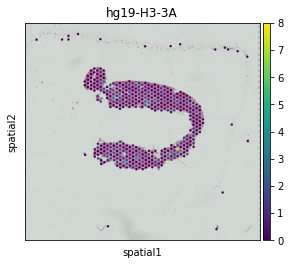

In [24]:
# we can still plot gene expression by name using standard scanpy functions as follows: 

sc.pl.spatial(adata_vis, color = 'hg19-H3-3A', gene_symbols = 'hg19-H3-3A')

In [25]:
adata_vis.var # checking set row names

,gene_ids,feature_types,genome,SYMBOL2
SYMBOL,,,,
hg19-OR4F16,hg19-ENSG00000284662,Gene Expression,hg19,hg19-OR4F16
hg19-TNFRSF4,hg19-ENSG00000186827,Gene Expression,hg19,hg19-TNFRSF4
hg19-TNFRSF18,hg19-ENSG00000186891,Gene Expression,hg19,hg19-TNFRSF18
hg19-ATAD3B,hg19-ENSG00000160072,Gene Expression,hg19,hg19-ATAD3B
hg19-THAP3,hg19-ENSG00000041988,Gene Expression,hg19,hg19-THAP3
...,...,...,...,...
ss11-ENSSSCG00000044642,ss11-ENSSSCG00000044642,Gene Expression,ss11,ss11-ENSSSCG00000044642
ss11-ENSSSCG00000034961,ss11-ENSSSCG00000034961,Gene Expression,ss11,ss11-ENSSSCG00000034961
ss11-ENSSSCG00000039856,ss11-ENSSSCG00000039856,Gene Expression,ss11,ss11-ENSSSCG00000039856


Mitochondia-encoded genes (gene names start with prefix mt- or MT-) are irrelevant for spatial mapping because their expression represents technical artifacts in the single cell and nucleus data rather than biological abundance of mitochondria. Yet these genes compose 15-40% of mRNA in each location. Hence, to avoid mapping artifacts it is strongly recommended to remove mitochondrial genes.

In [26]:
# find mitochondria-encoded (MT) genes
adata_vis.var['MT_gene'] = [gene.startswith('MT-') for gene in adata_vis.var['SYMBOL2']]
    
# remove MT genes for spatial mapping (keeping their counts in the object)
adata_vis.obsm['MT'] = adata_vis[:, adata_vis.var['MT_gene'].values].X.toarray()
adata_vis = adata_vis[:, ~adata_vis.var['MT_gene'].values]

### Loading snRNA-seq and scRNA-seq reference transcriptomes (sorted CD45+ cells + nuclei isolated from the core and wedge biopsies)

In [27]:
# reading ref data
adata_ref = sc.read_10x_mtx('Reference_Data/pbx_hpcd45_merged_10xmatrix', cache=False)

In [28]:
adata_ref

AnnData object with n_obs × n_vars = 14381 × 27536
    var: 'gene_ids'

In [29]:
adata_ref.obs # missing key cell type information so we shall load this data in subsequent sections

""
AAACCCAAGAAACTCA-1_1
AAACCCAAGGATACCG-1_1
AAACCCACAAAGTATG-1_1
AAACCCACATGTTCGA-1_1
AAACCCAGTGATGGCA-1_1
...
TTTGTTGGTAGCGAGT-1
TTTGTTGGTATACGGG-1
TTTGTTGTCACAAGAA-1
TTTGTTGTCAGAGTTC-1


### Loading and appending respective annotation data 
##### Meta data should have assigned cell types from conventional clustering workflows

In [30]:
anno = pd.read_csv("Reference_Data/metadata_pbx_hpcd45_merged.csv")
adata_ref.obs = anno

In [31]:
adata_ref.obs

,barcode,orig.ident,nCount_RNA,nFeature_RNA,sampleid,seurat_clusters_original,RNA_snn_res.0.8,seurat_clusters
0,AAACCCAAGAAACTCA-1_1,sample1,370,323,bx1,6,6,Pig Proximal Tubule
1,AAACCCAAGGATACCG-1_1,sample1,1058,738,bx1,2,2,Pig Proximal Tubule
2,AAACCCACAAAGTATG-1_1,sample1,1121,739,bx1,2,2,Pig Proximal Tubule
3,AAACCCACATGTTCGA-1_1,sample1,358,298,bx1,6,6,Pig Proximal Tubule
4,AAACCCAGTGATGGCA-1_1,sample1,1319,892,bx1,2,2,Pig Proximal Tubule
...,...,...,...,...,...,...,...,...
14376,TTTGTTGGTAGCGAGT-1,hpcd45,1331,628,hpcd45,0,0,Human Neutrophil
14377,TTTGTTGGTATACGGG-1,hpcd45,7090,1855,hpcd45,9,9,Human Monocyte
14378,TTTGTTGTCACAAGAA-1,hpcd45,1342,592,hpcd45,1,1,Human Neutrophil
14379,TTTGTTGTCAGAGTTC-1,hpcd45,3267,1076,hpcd45,0,0,Human Neutrophil


In [32]:
adata_ref.obs.set_index('barcode', drop = True, inplace = True)

In [33]:
type(adata_ref.obs)

pandas.core.frame.DataFrame

In [34]:
adata_ref.var

,gene_ids
hg19-ERRFI1,hg19-ERRFI1
hg19-SRRM1,hg19-SRRM1
hg19-SRSF10,hg19-SRSF10
hg19-WDTC1,hg19-WDTC1
hg19-CASZ1,hg19-CASZ1
...,...
ss11-ENSSSCG00000039956,ss11-ENSSSCG00000039956
ss11-ENSSSCG00000003282,ss11-ENSSSCG00000003282
ss11-ENSSSCG00000035756,ss11-ENSSSCG00000035756
ss11-PERVPOLYMERASE,ss11-PERVPOLYMERASE


In [35]:
adata_ref.var['SYMBOL'] = adata_ref.var['gene_ids']

In [36]:
adata_ref.var.index 

Index(['hg19-ERRFI1', 'hg19-SRRM1', 'hg19-SRSF10', 'hg19-WDTC1', 'hg19-CASZ1',
       'hg19-THRAP3', 'hg19-OSBPL9', 'hg19-ARID1A', 'hg19-NFIA', 'hg19-FOXJ3',
       ...
       'ss11-ENSSSCG00000039604', 'ss11-ENSSSCG00000040826',
       'ss11-ENSSSCG00000035457', 'ss11-ENSSSCG00000031855',
       'ss11-ENSSSCG00000032894', 'ss11-ENSSSCG00000039956',
       'ss11-ENSSSCG00000003282', 'ss11-ENSSSCG00000035756',
       'ss11-PERVPOLYMERASE', 'ss11-PERVAENV'],
      dtype='object', length=27536)

<div class="alert alert-info">
<b>Note!</b>
    
Before we estimate the reference cell type signature we recommend to perform very permissive genes selection. We prefer this to standard highly-variable-gene selection because our procedure keeps markers of rare genes while removing most of the uninformative genes.  
</div> 

**Discussed in-house given our prior analyses and workflows**
 
The default parameters `cell_count_cutoff=5, cell_percentage_cutoff2=0.03, nonz_mean_cutoff=1.12` are a good starting point, however, the cut-off can be increased to exclude more genes. To preserve marker genes of rare cell types it is recommended to set low `cell_count_cutoff=5`, however, `cell_percentage_cutoff2` and `nonz_mean_cutoff` can be increased to select between 8k-16k genes.

In this 2D histogram, orange rectangle highlights genes excluded based on the combination of number of cells expressing that gene (Y-axis) and average RNA count for cells where the gene was detected (X-axis).

Given our data were already pre-filtered, we are not filtering it herein.

In [37]:
## skipping this step as our data is already filtered- no need to refilter 

# from cell2location.utils.filtering import filter_genes
## selected = filter_genes(adata_ref, cell_count_cutoff=5, cell_percentage_cutoff2=0.03, nonz_mean_cutoff=1.12)
# selected = filter_genes(adata_ref, cell_count_cutoff=0.1, cell_percentage_cutoff2=0.001, nonz_mean_cutoff=0.1) #minimum or no filtering if data already filtered

## filter the object
# adata_ref = adata_ref[:, selected].copy()

In [38]:
adata_ref.uns

OverloadedDict, wrapping:
	OrderedDict()
With overloaded keys:
	['neighbors'].

In [39]:
adata_ref.X

<14381x27536 sparse matrix of type '<class 'numpy.float32'>'
	with 13542086 stored elements in Compressed Sparse Row format>

In [40]:
adata_ref.var

,gene_ids,SYMBOL
hg19-ERRFI1,hg19-ERRFI1,hg19-ERRFI1
hg19-SRRM1,hg19-SRRM1,hg19-SRRM1
hg19-SRSF10,hg19-SRSF10,hg19-SRSF10
hg19-WDTC1,hg19-WDTC1,hg19-WDTC1
hg19-CASZ1,hg19-CASZ1,hg19-CASZ1
...,...,...
ss11-ENSSSCG00000039956,ss11-ENSSSCG00000039956,ss11-ENSSSCG00000039956
ss11-ENSSSCG00000003282,ss11-ENSSSCG00000003282,ss11-ENSSSCG00000003282
ss11-ENSSSCG00000035756,ss11-ENSSSCG00000035756,ss11-ENSSSCG00000035756
ss11-PERVPOLYMERASE,ss11-PERVPOLYMERASE,ss11-PERVPOLYMERASE


In [41]:
sc.get.obs_df(adata_ref)

""
barcode
AAACCCAAGAAACTCA-1_1
AAACCCAAGGATACCG-1_1
AAACCCACAAAGTATG-1_1
AAACCCACATGTTCGA-1_1
AAACCCAGTGATGGCA-1_1
...
TTTGTTGGTAGCGAGT-1
TTTGTTGGTATACGGG-1
TTTGTTGTCACAAGAA-1


## Estimation of reference cell type signatures (Negative Binomial regression) <a class="anchor" id="Estimation-of-reference-cell-type-signatures-(NB-regression)"></a>

The signatures are estimated from scRNA-seq data, accounting for batch effects, using a Negative binomial regression model.

<div class="alert alert-block alert-message">
<b>Preparing anndata.</b>
    
First, prepare anndata object for the regression model:
</div>

In [42]:
# prepare anndata for the regression model
cell2location.models.RegressionModel.setup_anndata(adata=adata_ref, 
                        # 10X reaction / sample / batch
                        batch_key='sampleid', 
                        # cell type, covariate used for constructing signatures
                        labels_key='seurat_clusters', 
                        # multiplicative technical effects (platform, 3' vs 5', donor effect)
                        # categorical_covariate_keys=['Method']
                       )

In [43]:
# create the regression model
from cell2location.models import RegressionModel
mod = RegressionModel(adata_ref) 

# view anndata_setup as a sanity check
mod.view_anndata_setup()

Anndata setup with scvi-tools version 0.17.1.

Setup via `RegressionModel.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'sampleid',
│   'labels_key': 'seurat_clusters',
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│          n_vars          │ 27536 │
│         n_cells          │ 14381 │
│         n_batch          │   7   │
│         n_labels         │  13   │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    labels    │ adata.obs['_scvi_labels'] │
│    ind_x     │   adata.obs['_indices']   │
└──────────────┴───────────────────────────┘

                    batch State Registry                    
┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location    ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['sampleid'] │    bx1     │          0          │
│                       │    bx2     │          1          │
│                       │    bx3     │          2          │
│                       │    bx4     │          3          │
│                       │   hpcd45   │          4          │
│                       │     wl     │          5          │
│                       │     wr     │          6          │
└───────────────────────┴────────────┴─────────────────────┘

                            labels State Registry                             
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃       Source Location        ┃      Categories       ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['seurat_clusters'] │   Human Macrophage    │          0          │
│                              │    Human Monocyte     │          1          │
│                              │       Human NK        │          2          │
│                              │   Human Neutrophil    │          3          │
│                              │  Pig Collecting Duct  │          4          │
│                              │    Pig Endothelial    │          5          │
│                              │ Pig Intercalated Cell │          6          │
│                              │   Pig Loop of Henle   │          7          │
│                              │    Pig Macrophage     │          8          │
│                              │    Pig Neutrophil     │          9          │
│                              │  Pig Proximal Tubule  │         10          │
│                              │      Pig Stromal      │         11          │
│                              │      Pig T Cells      │         12          │
└──────────────────────────────┴───────────────────────┴─────────────────────┘

<div class="alert alert-block alert-message">
<b>Training model.</b>
    
Now we train the model to estimate the reference cell type signatures. 
    
Note that to achieve convergence on our data (=to get stabilization of the loss) we may need to increase `max_epochs=250`.
    
Also note that here we are using `batch_size=2500` which is much larger than scvi-tools default and perform training on all cells in the data (`train_size=1`) - both parameters are defaults.
</div>

In [44]:
mod.train(max_epochs = 600, use_gpu = True) 

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 600/600: 100%|██████████| 600/600 [17:57<00:00,  1.80s/it, v_num=1, elbo_train=4.72e+7]


<div class="alert alert-block alert-message">
<b>Determine if the model needs more training.</b>
</div>

Here, we plot ELBO (evidence lower bound) loss history during training, removing first 20 epochs from the plot.
This plot should have a decreasing trend and level off by the end of training. If it is still decreasing, increase `max_epochs`.


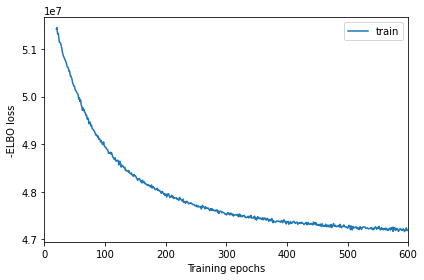

In [45]:
mod.plot_history(20)

In [46]:
# in this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_ref = mod.export_posterior(
    adata_ref, sample_kwargs = {'num_samples': 1000, 'batch_size': 2500, 'use_gpu': True}
)

# save model
mod.save(f"{ref_run_name}", overwrite = True)

# save anndata object with results
adata_file = f"{ref_run_name}/sc.h5ad"
adata_ref.write(adata_file)
adata_file

Sampling global variables, sample: 100%|██████████| 999/999 [00:19<00:00, 51.13it/s]


'./xeno_cell2location_results/bx1_analysis//reference_signatures/sc.h5ad'

<div class="alert alert-block alert-message">
<b>Examine QC plots.</b>
</div>

1. Reconstruction accuracy to assess if there are any issues with inference. This 2D histogram plot should have most observations along a noisy diagonal. 

2. The estimated expression signatures are distinct from mean expression in each cluster because of batch effects. For some scRNA-seq datasets which do not suffer from batch effect, cluster average expression can be used instead of estimating signatures with a model. When this plot is very different from a diagonal plot (e.g. very low values on Y-axis, density everywhere) it indicates problems with signature estimation.

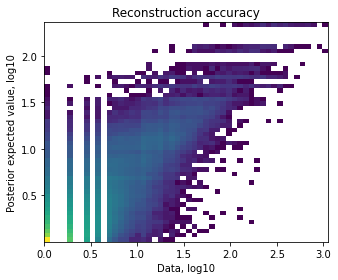

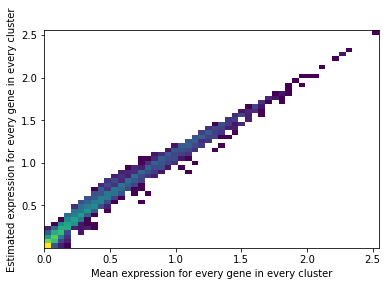

In [47]:
mod.plot_QC()

The model and output h5ad can be loaded later like this:
```python
adata_file = f"{ref_run_name}/sc.h5ad"
adata_ref = sc.read_h5ad(adata_file)
mod = cell2location.models.RegressionModel.load(f"{ref_run_name}", adata_ref)
```

<div class="alert alert-block alert-message">
<b>Extracting reference cell types signatures as a pd.DataFrame.</b>
    
All parameters of the a Negative Binomial regression model are exported into reference anndata object, however for spatial mapping we just need the estimated expression of every gene in every cell type. Here we extract that from standard output:
</div>

In [48]:
# export estimated expression in each cluster
if 'means_per_cluster_mu_fg' in adata_ref.varm.keys():
    inf_aver = adata_ref.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}' 
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
else:
    inf_aver = adata_ref.var[[f'means_per_cluster_mu_fg_{i}' 
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
inf_aver.columns = adata_ref.uns['mod']['factor_names']
inf_aver.iloc[0:5, 0:5]

,Human Macrophage,Human Monocyte,Human NK,Human Neutrophil,Pig Collecting Duct
hg19-ERRFI1,0.127562,0.016773,0.312337,0.023303,0.008595
hg19-SRRM1,1.884271,1.839919,1.261650,0.257971,0.036100
hg19-SRSF10,0.908831,0.865669,0.816947,0.065615,0.027412
hg19-WDTC1,0.097752,0.094104,0.178912,0.049880,0.004172
hg19-CASZ1,0.013707,0.041099,0.072497,0.001290,0.042913


## Cell2location: spatial mapping <a class="anchor" id="Cell2location:-spatial-mapping"></a>

<div class="alert alert-block alert-message">
<b>Find shared genes and prepare anndata.</b>
Subset both anndata and reference signatures:
</div>

In [49]:
inf_aver_bx1 = inf_aver
from pathlib import Path  
filepath = Path('./xeno_cell2location_results/tables/inf_aver_bx1.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
inf_aver_bx1.to_csv(filepath) 

In [50]:
# checking that ref and spatial names are in similar format before merger
adata_vis.var_names

Index(['hg19-OR4F16', 'hg19-TNFRSF4', 'hg19-TNFRSF18', 'hg19-ATAD3B',
       'hg19-THAP3', 'hg19-PRDM16', 'hg19-PRKCZ', 'hg19-ACAP3', 'hg19-PUSL1',
       'hg19-PEX10',
       ...
       'ss11-ENSSSCG00000035401', 'ss11-ENSSSCG00000034712',
       'ss11-ENSSSCG00000016385', 'ss11-ENSSSCG00000033640',
       'ss11-ENSSSCG00000037347', 'ss11-ENSSSCG00000044642',
       'ss11-ENSSSCG00000034961', 'ss11-ENSSSCG00000039856',
       'ss11-ENSSSCG00000040882', 'ss11-ENSSSCG00000034846'],
      dtype='object', name='SYMBOL', length=41914)

In [51]:
inf_aver.index

Index(['hg19-ERRFI1', 'hg19-SRRM1', 'hg19-SRSF10', 'hg19-WDTC1', 'hg19-CASZ1',
       'hg19-THRAP3', 'hg19-OSBPL9', 'hg19-ARID1A', 'hg19-NFIA', 'hg19-FOXJ3',
       ...
       'ss11-ENSSSCG00000039604', 'ss11-ENSSSCG00000040826',
       'ss11-ENSSSCG00000035457', 'ss11-ENSSSCG00000031855',
       'ss11-ENSSSCG00000032894', 'ss11-ENSSSCG00000039956',
       'ss11-ENSSSCG00000003282', 'ss11-ENSSSCG00000035756',
       'ss11-PERVPOLYMERASE', 'ss11-PERVAENV'],
      dtype='object', length=27536)

In [52]:
# find shared genes and subset both anndata and reference signatures
intersect = np.intersect1d(adata_vis.var_names, inf_aver.index)
adata_vis = adata_vis[:, intersect].copy()
inf_aver = inf_aver.loc[intersect, :].copy()

# prepare anndata for cell2location model
cell2location.models.Cell2location.setup_anndata(adata=adata_vis, batch_key="sample")

<div class="alert alert-info">
<b> Important </b>
    
To use cell2location spatial mapping model, we need to specify 2 user-provided hyperparameters (`N_cells_per_location` and `detection_alpha`) - for detailed guidance on setting these hyperparameters and their impact see [the flow diagram and the note](https://github.com/BayraktarLab/cell2location/blob/master/docs/images/Note_on_selecting_hyperparameters.pdf).
</div>

**Choosing hyperparameter `N_cells_per_location`!**

It is useful to adapt the expected cell abundance `N_cells_per_location` to every tissue</b>. This value can be estimated from paired histology images and as described in the note above.

**Choosing hyperparameter `detection_alpha`!**

To improve accuracy & sensitivity on datasets with large technical variability in RNA detection sensitivity within the slide/batch - regularisation of per-location normalisation needs to be relaxed (use `detection_alpha=20`). High technical variability in RNA detection sensitivity is present in a sample when we observe the spatial distribution of total RNA count per location that doesn't match expected cell numbers based on histological examination. 

We can opt for high regularisation (`detection_alpha=200`) if our datasets have low technical effects and using high regularisation strength improves consistencly between total estimated cell abundance per location and the nuclei count quantified from histology ([Fig S8F in cell2location paper](https://static-content.springer.com/esm/art%3A10.1038%2Fs41587-021-01139-4/MediaObjects/41587_2021_1139_MOESM1_ESM.pdf)). However, Visium experiments on human tissues suffer from technical effects and if this is observed or expected, set `detection_alpha=20` - recommended to test both.

In [53]:
# create and train the model
mod = cell2location.models.Cell2location(
    adata_vis, cell_state_df=inf_aver, 
    # the expected average cell abundance: tissue-dependent 
    # hyper-prior which can be estimated from paired histology:
    N_cells_per_location=6.6,
    # hyperparameter controlling normalisation of
    # within-experiment variation in RNA detection:
    detection_alpha=20
) 
mod.view_anndata_setup()

Anndata setup with scvi-tools version 0.17.1.

Setup via `Cell2location.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'sample',
│   'labels_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│          n_vars          │ 27528 │
│         n_cells          │  430  │
│         n_batch          │   1   │
│         n_labels         │   1   │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    labels    │ adata.obs['_scvi_labels'] │
│    ind_x     │   adata.obs['_indices']   │
└──────────────┴───────────────────────────┘

                   batch State Registry                   
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['sample'] │ D4BX1R_ph  │          0          │
└─────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

<div class="alert alert-block alert-message">
<b>Training cell2location:</b>
</div>

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 30000/30000: 100%|██████████| 30000/30000 [39:27<00:00, 12.67it/s, v_num=1, elbo_train=2.11e+6]


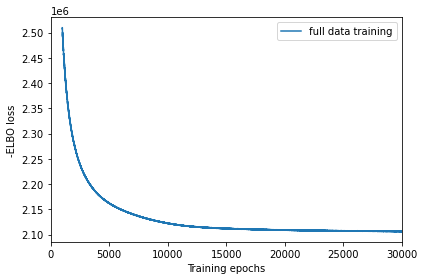

In [54]:
mod.train(max_epochs = 30000, 
          # train using full data (batch_size=None)
          batch_size = None, 
          # use all data points in training because 
          # we need to estimate cell abundance at all locations
          train_size = 1,
          use_gpu = True)

# plot ELBO loss history during training, removing first 1000 epochs from the plot
mod.plot_history(1000)
plt.legend(labels = ['full data training']);

<div class="alert alert-block alert-message">
<b>Exporting estimated posterior distributions of cell abundance and saving results:</b>
</div>

In [55]:
# in this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_vis = mod.export_posterior(
    adata_vis, sample_kwargs = {'num_samples': 1000, 'batch_size': mod.adata.n_obs, 'use_gpu': True}
)

# save model
mod.save(f"{run_name}", overwrite = True)

# mod = cell2location.models.Cell2location.load(f"{run_name}", adata_vis)

# save anndata object with results
adata_file = f"{run_name}/sp.h5ad"
adata_vis.write(adata_file)
adata_file

Sampling global variables, sample: 100%|██████████| 999/999 [00:18<00:00, 54.49it/s]


'./xeno_cell2location_results/bx1_analysis//cell2location_map/sp.h5ad'

The model and output h5ad can be loaded later like this:
```python
adata_file = f"{run_name}/sp.h5ad"
adata_vis = sc.read_h5ad(adata_file)
mod = cell2location.models.Cell2location.load(f"{run_name}", adata_vis)
```

<div class="alert alert-block alert-message">
<b>Assessing mapping quality.</b>
Examine reconstruction accuracy to assess if there are any issues with mapping.
The plot should be roughly diagonal, strong deviations will signal problems that need to be investigated.
</div>

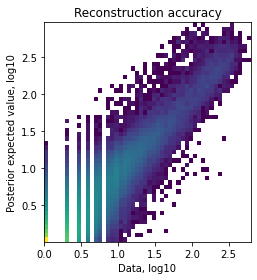

In [56]:
# mod.export_posterior(adata_vis) 
mod.plot_QC()

When intergrating multiple spatial batches and when working with datasets that have substantial variation of detected RNA within slides (that cannot be explained by high cellular density in the histology), it is important to assess whether cell2location normalised those effects. We expect to see similar total cell abundance across batches but distinct RNA detection sensitivity (both estimated by cell2location). We expect total cell abundance to mirror high cellular density in the histology.

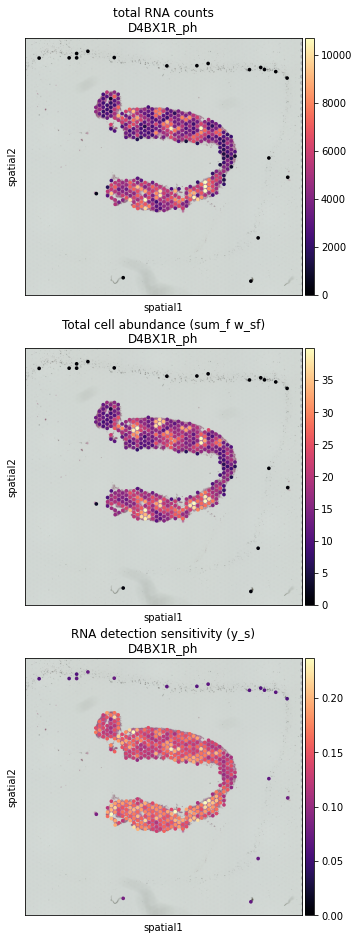

In [79]:
fig = mod.plot_spatial_QC_across_batches()

## Visualising cell abundance in spatial coordinates <a class="anchor" id="Visualising-cell-abundance-in-spatial-coordinates"></a>

<div class="alert alert-info">
Note
    
We use 5% quantile of the posterior distribution, representing the value of cell abundance that the model has high confidence in (aka 'at least this amount is present').
</div>

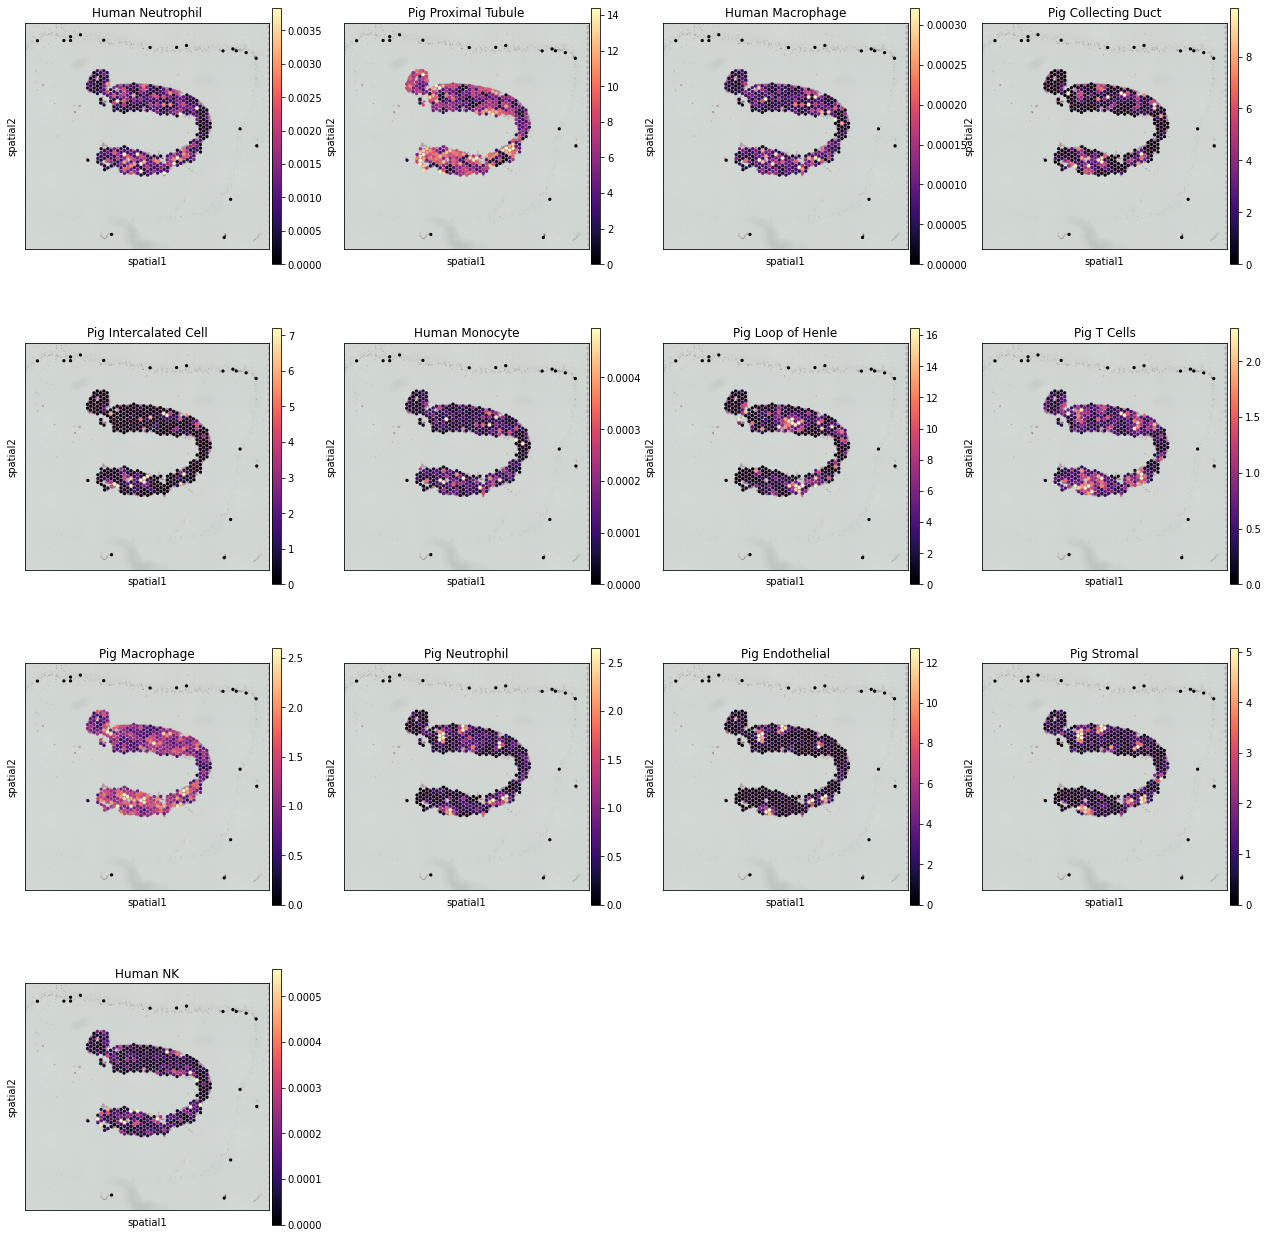

In [58]:
# add 5% quantile, representing confident cell abundance, 'at least this amount is present', 
adata_vis.obs[adata_vis.uns['mod']['factor_names']] = adata_vis.obsm['q05_cell_abundance_w_sf']

# select one slide
from cell2location.utils import select_slide
slide = select_slide(adata_vis, 'D4BX1R_ph')
    
# plot in spatial coordinates
with mpl.rc_context({'axes.facecolor':  'black',
                     'figure.figsize': [4.5, 5]}):
    
    sc.pl.spatial(slide, cmap = 'magma',
                  # show first 8 cell types
                  color = ['Human Neutrophil',      'Pig Proximal Tubule' ,  'Human Macrophage',      'Pig Collecting Duct',   'Pig Intercalated Cell', 'Human Monocyte'  ,     
'Pig Loop of Henle',     'Pig T Cells' ,          'Pig Macrophage' ,       'Pig Neutrophil'  ,      'Pig Endothelial',       'Pig Stromal'   ,       
'Human NK'], 
                  ncols = 4, size = 1.3, 
                  img_key='hires',
                  # limit color scale at 98% quantile of cell abundance
                  vmin=0, vmax='p98' #note different scales per tissue
                 )

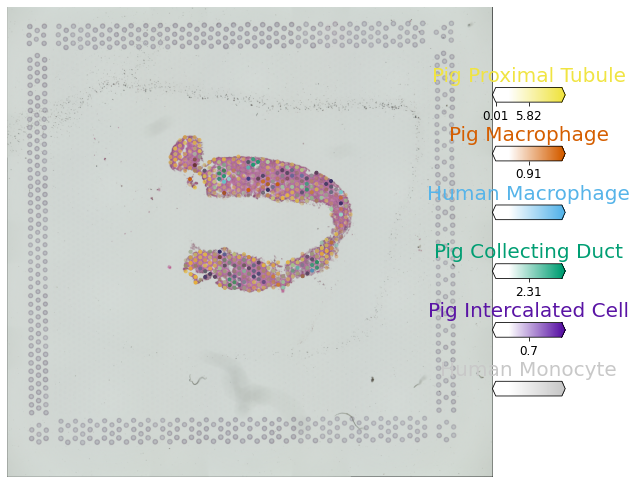

In [59]:
# now we use cell2location plotter that allows showing multiple cell types in one panel
from cell2location.plt import plot_spatial

# select up to 6 clusters 
clust_labels = ['Pig Proximal Tubule' ,  'Pig Macrophage', 'Human Macrophage',      'Pig Collecting Duct',   'Pig Intercalated Cell', 'Human Monocyte' ]
clust_col = ['' + str(i) for i in clust_labels] # in case column names differ from labels

slide = select_slide(adata_vis, 'D4BX1R_ph')

with mpl.rc_context({'figure.figsize': (10, 10)}):
    fig = plot_spatial(
        adata = slide, 
        # labels to show on a plot
        color = clust_col, labels=clust_labels, 
        show_img = True,
        # 'fast' (white background) or 'dark_background'
        style = 'fast', 
        # limit color scale at 90% quantile of cell abundance
        max_color_quantile = 0.9,
        # size of locations (adjust depending on figure size)
        circle_diameter = 3, 
        colorbar_position = 'right'
    )

## Downstream analysis <a class="anchor" id="Downstream-analysis"></a>

### Identifying discrete tissue regions by Leiden clustering<a class="anchor" id="Identifying-discrete-tissue-regions-by-Leiden-clustering"></a>

Tissue regions that differ in their cell composition are identified by clustering locations using cell abundance estimated by cell2location. 

Tissue regions are found by clustering Visium spots using estimated cell abundance of each cell type. A K-nearest neigbour (KNN) graph is constructed representing similarity of locations in estimated cell abundance and then Leiden clustering is applied. The number of KNN neighbours should be adapted to dataset size and the size of anatomically defined regions. This can be done for a range KNN neighbours and Leiden clustering resolutions until a clustering matching the anatomical structure of the tissue is obtained. 

The clustering is done jointly across all Visium sections / batches, hence the region identities are directly comparable. When there are strong technical effects between multiple batches `sc.external.pp.bbknn` can be in principle used to account for those effects during the KNN construction.

The resulting clusters are saved in `adata_vis.obs['region_cluster']`.

In [60]:
adata_vis.obs

,in_tissue,array_row,array_col,sample,_indices,_scvi_batch,_scvi_labels,total RNA counts,Total cell abundance (sum_f w_sf),RNA detection sensitivity (y_s),...,Human Neutrophil,Pig Collecting Duct,Pig Endothelial,Pig Intercalated Cell,Pig Loop of Henle,Pig Macrophage,Pig Neutrophil,Pig Proximal Tubule,Pig Stromal,Pig T Cells
AAACGAGACGGTTGAT-1,1,35,79,D4BX1R_ph,0,0,0,4820.0,21.949568,0.158013,...,7.210864e-04,1.567954,3.312139,0.114710,0.917559,0.823944,0.656820,5.356058,3.763156,1.842888
AAATAAGGTAGTGCCC-1,1,31,115,D4BX1R_ph,1,0,0,103.0,0.865247,0.081963,...,4.351016e-07,0.000551,0.007809,0.000158,0.026738,0.029880,0.000174,0.407372,0.000926,0.007427
AACAGGATGGGCCGCG-1,1,29,31,D4BX1R_ph,2,0,0,7064.0,20.272755,0.216993,...,1.228073e-03,0.019224,0.436904,0.037389,0.283171,1.555830,0.069958,15.107328,0.485423,0.283616
AACGATAATGCCGTAG-1,1,53,73,D4BX1R_ph,3,0,0,12127.0,38.463131,0.216449,...,2.927033e-03,16.301420,0.420240,8.132657,2.356144,2.764647,0.970358,0.195663,0.189460,3.044838
AACGATATGTCAACTG-1,1,24,76,D4BX1R_ph,4,0,0,475.0,3.108303,0.083386,...,1.161765e-05,0.008108,0.010738,0.003551,0.312321,0.221365,0.002875,1.428550,0.025532,0.058898
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGGATATCGTCTACG-1,1,48,52,D4BX1R_ph,425,0,0,1229.0,6.513729,0.107078,...,6.818180e-05,0.275164,0.024890,0.216126,0.253883,0.363148,0.095610,3.378163,0.031355,0.195684
TTGGGACACTGCCCGC-1,1,28,70,D4BX1R_ph,426,0,0,2498.0,10.450986,0.131528,...,1.899766e-04,0.255273,0.104529,0.353611,0.219731,0.995698,0.013856,6.503412,0.030820,0.127071
TTGGGCGGCGGTTGCC-1,1,30,76,D4BX1R_ph,427,0,0,4851.0,22.194382,0.138667,...,2.267640e-03,3.757079,1.434072,2.277573,1.219834,1.516075,0.486445,4.747956,0.947019,1.596077
TTGGTCACACTCGTAA-1,1,48,48,D4BX1R_ph,428,0,0,3193.0,13.613152,0.149226,...,3.108742e-04,0.215690,0.631504,0.020635,2.650922,1.026738,0.129174,5.842090,0.529409,0.112781


In [61]:
adata_vis_obs_bx1 = adata_vis.obs
from pathlib import Path  
filepath = Path('./xeno_cell2location_results/tables/adata_vis_obs_bx1.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
adata_vis_obs_bx1.to_csv(filepath) 

In [62]:
import leidenalg
# compute KNN using the cell2location output stored in adata.obsm
sc.pp.neighbors(adata_vis, use_rep = 'q05_cell_abundance_w_sf',
                n_neighbors = 15)

# cluster spots into regions using scanpy
sc.tl.leiden(adata_vis, resolution=1.1)

# add region as categorical variable
adata_vis.obs["region_cluster"] = adata_vis.obs["leiden"].astype("category")

We can use the location composition similarity graph to build a joint integrated UMAP representation of all section/Visium batches.

In [63]:
adata_vis.obs

,in_tissue,array_row,array_col,sample,_indices,_scvi_batch,_scvi_labels,total RNA counts,Total cell abundance (sum_f w_sf),RNA detection sensitivity (y_s),...,Pig Endothelial,Pig Intercalated Cell,Pig Loop of Henle,Pig Macrophage,Pig Neutrophil,Pig Proximal Tubule,Pig Stromal,Pig T Cells,leiden,region_cluster
AAACGAGACGGTTGAT-1,1,35,79,D4BX1R_ph,0,0,0,4820.0,21.949568,0.158013,...,3.312139,0.114710,0.917559,0.823944,0.656820,5.356058,3.763156,1.842888,0,0
AAATAAGGTAGTGCCC-1,1,31,115,D4BX1R_ph,1,0,0,103.0,0.865247,0.081963,...,0.007809,0.000158,0.026738,0.029880,0.000174,0.407372,0.000926,0.007427,12,12
AACAGGATGGGCCGCG-1,1,29,31,D4BX1R_ph,2,0,0,7064.0,20.272755,0.216993,...,0.436904,0.037389,0.283171,1.555830,0.069958,15.107328,0.485423,0.283616,8,8
AACGATAATGCCGTAG-1,1,53,73,D4BX1R_ph,3,0,0,12127.0,38.463131,0.216449,...,0.420240,8.132657,2.356144,2.764647,0.970358,0.195663,0.189460,3.044838,5,5
AACGATATGTCAACTG-1,1,24,76,D4BX1R_ph,4,0,0,475.0,3.108303,0.083386,...,0.010738,0.003551,0.312321,0.221365,0.002875,1.428550,0.025532,0.058898,12,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGGATATCGTCTACG-1,1,48,52,D4BX1R_ph,425,0,0,1229.0,6.513729,0.107078,...,0.024890,0.216126,0.253883,0.363148,0.095610,3.378163,0.031355,0.195684,0,0
TTGGGACACTGCCCGC-1,1,28,70,D4BX1R_ph,426,0,0,2498.0,10.450986,0.131528,...,0.104529,0.353611,0.219731,0.995698,0.013856,6.503412,0.030820,0.127071,3,3
TTGGGCGGCGGTTGCC-1,1,30,76,D4BX1R_ph,427,0,0,4851.0,22.194382,0.138667,...,1.434072,2.277573,1.219834,1.516075,0.486445,4.747956,0.947019,1.596077,5,5
TTGGTCACACTCGTAA-1,1,48,48,D4BX1R_ph,428,0,0,3193.0,13.613152,0.149226,...,0.631504,0.020635,2.650922,1.026738,0.129174,5.842090,0.529409,0.112781,4,4


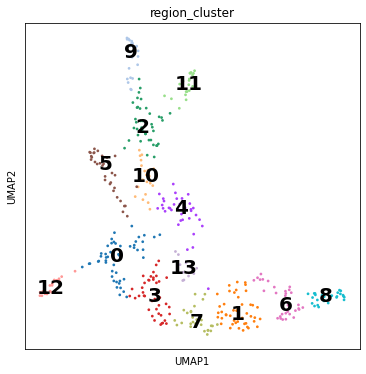

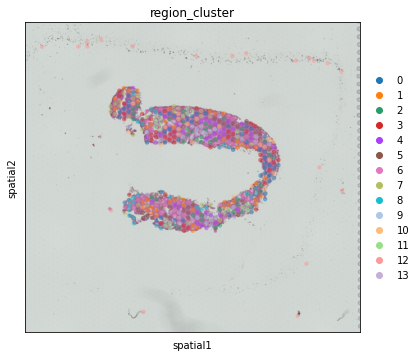

In [64]:
# compute UMAP using KNN graph based on the cell2location output
sc.tl.umap(adata_vis, min_dist = 0.3, spread = 1)

# show regions in UMAP coordinates
with mpl.rc_context({'axes.facecolor':  'white',
                     'figure.figsize': [6, 6]}):
    sc.pl.umap(adata_vis, color=['region_cluster'], size=30,
               color_map = 'RdPu', ncols = 2, legend_loc='on data',
               legend_fontsize=20)
   # sc.pl.umap(adata_vis, color=['sample'], size=30,
    #           color_map = 'RdPu', ncols = 2,
     #          legend_fontsize=20)

# plot in spatial coordinates
with mpl.rc_context({'axes.facecolor':  'black',
                     'figure.figsize': [6, 6]}):
    sc.pl.spatial(adata_vis, color=['region_cluster'], 
                  size=1.3, img_key='hires', alpha=0.5)

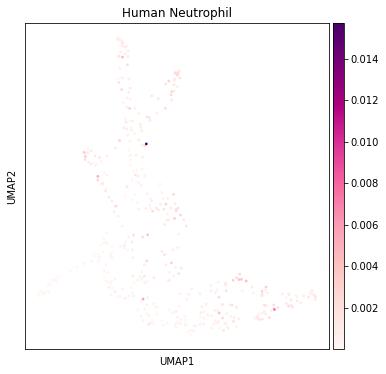

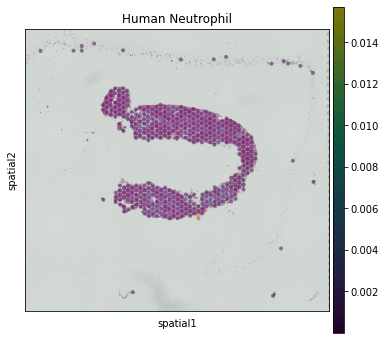

In [65]:
# compute UMAP using KNN graph based on the cell2location output
sc.tl.umap(adata_vis, min_dist = 0.3, spread = 1)

# show regions in UMAP coordinates
with mpl.rc_context({'axes.facecolor':  'white',
                     'figure.figsize': [6, 6]}):
    sc.pl.umap(adata_vis, color=['Human Neutrophil'], size=30,
               color_map = 'RdPu', ncols = 2, legend_loc='on data',
               legend_fontsize=20)
   # sc.pl.umap(adata_vis, color=['sample'], size=30,
          #     color_map = 'RdPu', ncols = 2,
          #     legend_fontsize=20)

# plot in spatial coordinates
with mpl.rc_context({'axes.facecolor':  'black',
                     'figure.figsize': [6, 6]}):
    sc.pl.spatial(adata_vis, color=['Human Neutrophil'], 
                  size=1.3, img_key='hires', alpha=0.5)

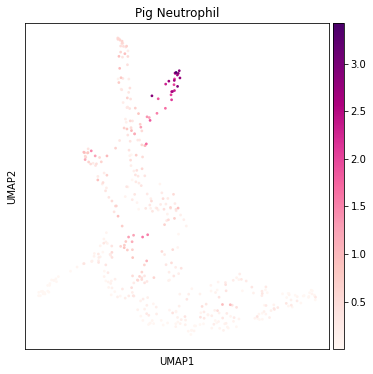

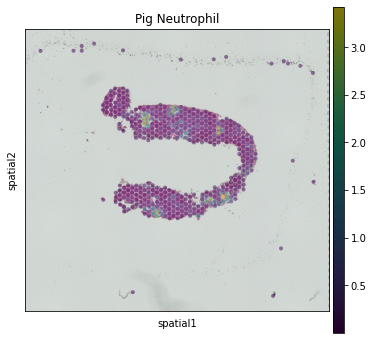

In [66]:
# compute UMAP using KNN graph based on the cell2location output
sc.tl.umap(adata_vis, min_dist = 0.3, spread = 1)

# show regions in UMAP coordinates
with mpl.rc_context({'axes.facecolor':  'white',
                     'figure.figsize': [6, 6]}):
    sc.pl.umap(adata_vis, color=['Pig Neutrophil'], size=30,
               color_map = 'RdPu', ncols = 2, legend_loc='on data',
               legend_fontsize=20)

# plot in spatial coordinates
with mpl.rc_context({'axes.facecolor':  'black',
                     'figure.figsize': [6, 6]}):
    sc.pl.spatial(adata_vis, color=['Pig Neutrophil'], 
                  size=1.3, img_key='hires', alpha=0.5)

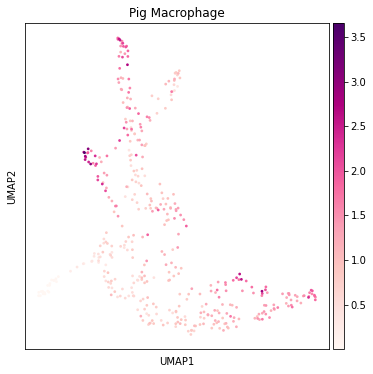

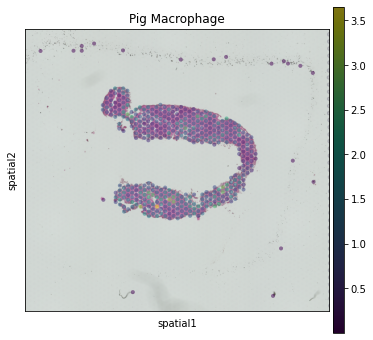

In [67]:
# compute UMAP using KNN graph based on the cell2location output
sc.tl.umap(adata_vis, min_dist = 0.3, spread = 1)

# show regions in UMAP coordinates
with mpl.rc_context({'axes.facecolor':  'white',
                     'figure.figsize': [6, 6]}):
    sc.pl.umap(adata_vis, color=['Pig Macrophage'], size=30,
               color_map = 'RdPu', ncols = 2, legend_loc='on data',
               legend_fontsize=20)

# plot in spatial coordinates
with mpl.rc_context({'axes.facecolor':  'black',
                     'figure.figsize': [6, 6]}):
    sc.pl.spatial(adata_vis, color=['Pig Macrophage'], 
                  size=1.3, img_key='hires', alpha=0.5)

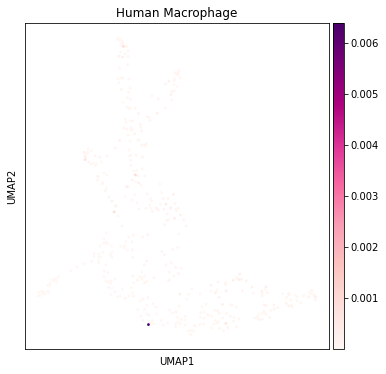

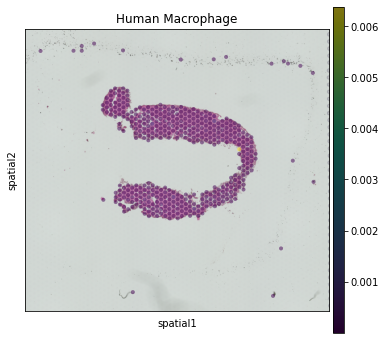

In [68]:
with mpl.rc_context({'axes.facecolor':  'white',
                     'figure.figsize': [6, 6]}):
    sc.pl.umap(adata_vis, color=['Human Macrophage'], size=30,
               color_map = 'RdPu', ncols = 2, legend_loc='on data',
               legend_fontsize=20)

# plot in spatial coordinates
with mpl.rc_context({'axes.facecolor':  'black',
                     'figure.figsize': [6, 6]}):
    sc.pl.spatial(adata_vis, color=['Human Macrophage'], 
                  size=1.3, img_key='hires', alpha=0.5)

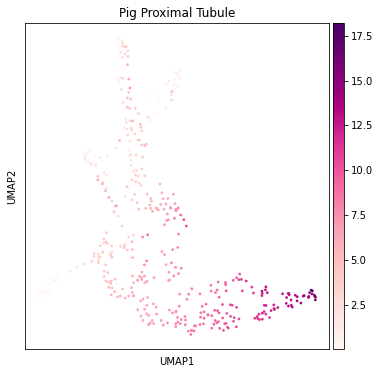

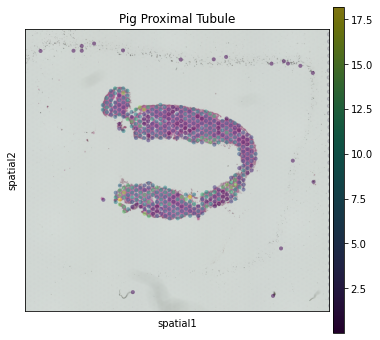

In [69]:
with mpl.rc_context({'axes.facecolor':  'white',
                     'figure.figsize': [6, 6]}):
    sc.pl.umap(adata_vis, color=['Pig Proximal Tubule'], size=30,
               color_map = 'RdPu', ncols = 2, legend_loc='on data',
               legend_fontsize=20)

# plot in spatial coordinates
with mpl.rc_context({'axes.facecolor':  'black',
                     'figure.figsize': [6, 6]}):
    sc.pl.spatial(adata_vis, color=['Pig Proximal Tubule'], 
                  size=1.3, img_key='hires', alpha=0.5)

### Identifying cellular compartments / tissue zones using Non-Negative Matrix Factorization (NMF) <a name="Identifying-cellular-compartments-/-tissue-zones-using-matrix-factorisation-(NMF)"></a>

The cell2location mapping results are used to identify the spatial co-occurrence of cell types in order to better understand the tissue organisation and predict cellular interactions. Non-negative matrix factorization (NMF) of the cell type abundance estimates from cell2location is performed ([paper section 4, Fig 4D](https://www.nature.com/articles/s41587-021-01139-4)). Similar to the established benefits of applying NMF to conventional scRNA-seq, the additive NMF decomposition yields a grouping of spatial cell type abundance profiles into components that capture co-localised cell types ([Supplemenary Methods section 4.2, p. 60](https://www.nature.com/articles/s41587-021-01139-4#Sec50)). This NMF-based decomposition naturally accounts for the fact that multiple cell types and microenvironments can co-exist at the same Visium locations (see [paper Fig S20, p. 34](https://www.nature.com/articles/s41587-021-01139-4#Sec50)), while sharing information across tissue areas (e.g. individual germinal centres). 


<div class="alert alert-block alert-primary">
<b>Tip</b>
    
In practice, it is better to train NMF for a range of factors $R={5, .., 30}$ and select $R$ as a balance between capturing fine-grained and splitting known well-established tissue zones. 

*Use a small number of factors if you want to find a few most disctinct cellular compartments.   
*Use a lot of factors if you want to find very strong co-location signal and assume that most cell types don't co-locate (e.g > 30 used in tutorial).
</div>

In [70]:
# from cell2location import run_colocation
# res_dict, adata_vis = run_colocation(
#     adata_vis, 
#     model_name='CoLocatedGroupsSklearnNMF',
#     train_args={
#       'n_fact': np.arange(11, 13), # IMPORTANT: use a wider range of the number of factors (5-30)
#       'sample_name_col': 'sample', # columns in adata_vis.obs that identifies sample           
#       'n_restarts': 3 # number of training restarts
#     },
#     export_args={'path': f'{run_name}/CoLocatedComb/'}
# )  

For every factor number, the model produces the following list of folder outputs:

`cell_type_fractions_heatmap/`: a dot plot of the estimated NMF weights of cell types (rows) across NMF components (columns)

`cell_type_fractions_mean/`: the data used for dot plot

`factor_markers/`: tables listing top 10 cell types most speficic to each NMF factor

`models/`: saved NMF models

`predictive_accuracy/`: 2D histogram plot showing how well NMF explains cell2location output

`spatial/`: NMF weights across locatinos in spatial coordinates

`location_factors_mean/`: the data used for the plot in spatial coordiantes

`stability_plots/`: stability of NMF weights between training restarts

Key output that we want to examine are the files in `cell_type_fractions_heatmap/` which show a dot plot of the estimated NMF weights of cell types (rows) across NMF components (columns) which correspond to cellular compartments. Shown are relative weights, normalized across components for every cell type.

<div class="alert alert-block alert-primary">
<b>Tip</b>
    
The NMF model output such as factor loadings are stored in `adata.uns[f"mod_coloc_n_fact{n_fact}"]` in a similar output format as main cell2location results in `adata.uns['mod']`.
</div>

In [71]:
# here we plot the NMF weights (same as saved to `cell_type_fractions_heatmap`)
# res_dict['n_fact12']['mod'].plot_cell_type_loadings() 

### Estimate cell-type specific expression of every gene in the spatial data (needed for NCEM) <a name="Estimate-cell-type-specific-expression-of-every-gene-in-the-spatial-data-(needed-for-NCEM)"></a>

The cell-type specific expression of every gene at every spatial location in the spatial data enables learning cell communication with NCEM model using Visium data (https://github.com/theislab/ncem). 

To derive this, we adapt the approach of estimating conditional expected expression proposed by [RCTD (Cable et al)](https://pubmed.ncbi.nlm.nih.gov/33603203/) method. 

With cell2location, we can look at the posterior distribution rather than just point estimates of cell type specific expression (see `mod.samples.keys()` and next section on using full distribution).

Note that this analysis requires substantial amount RAM memory.

In [72]:
# compute expected expression per cell type
expected_dict = mod.module.model.compute_expected_per_cell_type(
    mod.samples["post_sample_q05"], mod.adata_manager
)

# add to anndata layers
for i, n in enumerate(mod.factor_names_):
    adata_vis.layers[n] = expected_dict['mu'][i]

# save anndata object with results
adata_file = f"{run_name}/sp.h5ad"
adata_vis.write(adata_file)
adata_file

'./xeno_cell2location_results/bx1_analysis//cell2location_map/sp.h5ad'

<div class="alert alert-block alert-primary">
<b>Plotting cell-type specific expression of genes in spatial coordinates.</b>
    
Below we plot the cell-type specific expression of genes (rows, second to last columns) compared to total expression of those genes (first column).
</div>

In [73]:
import matplotlib.pyplot as plt
import scanpy as sc
import numpy as np


def plot_genes_per_cell_type(slide, genes, ctypes):

    n_genes = len(genes)
    n_ctypes = len(ctypes)
    fig, axs = plt.subplots(
        nrows = n_genes, ncols = n_ctypes + 1, figsize=(4.5 * (n_ctypes + 1) + 2, 5 * n_genes + 1), squeeze = False
    )
    # axs = axs.reshape((n_genes, n_ctypes+1))

    # plots of every gene
    for j in range(n_genes):

        # limit color scale at 99.2% quantile of gene expression (computed across cell types)
        quantile_across_ct = np.array(
            [
                np.quantile(slide.layers[n][:, slide.var["SYMBOL2"] == genes[j]].toarray(), 0.992)
                for n in slide.uns["mod"]["factor_names"]
            ]
        )
        quantile_across_ct = np.partition(quantile_across_ct.flatten(), -2)[-2]
        sc.pl.spatial(
            slide,
            cmap = "magma",
            color = genes[j],
            # layer=ctypes[i],
            gene_symbols = "SYMBOL2",
            ncols = 4,
            size = 1.3,
            img_key = "hires",
            # limit color scale at 99.2% quantile of gene expression
            vmin = 0,
            vmax = "p100",
            ax = axs[j, 0],
            show = False,
        )

        # plots of every cell type
        for i in range(n_ctypes):
            sc.pl.spatial(
                slide,
                cmap = "magma",
                color = genes[j],
                layer = ctypes[i],
                gene_symbols = "SYMBOL2",
                ncols = 4,
                size = 1.3,
                img_key = "hires",
                # limit color scale at 99.2% quantile of gene expression
                vmin = 0,
                vmax = quantile_across_ct,
                ax = axs[j, i + 1],
                show = False,
            )
            axs[j, i + 1].set_title(f"{genes[j]} {ctypes[i]}")

    return fig, axs

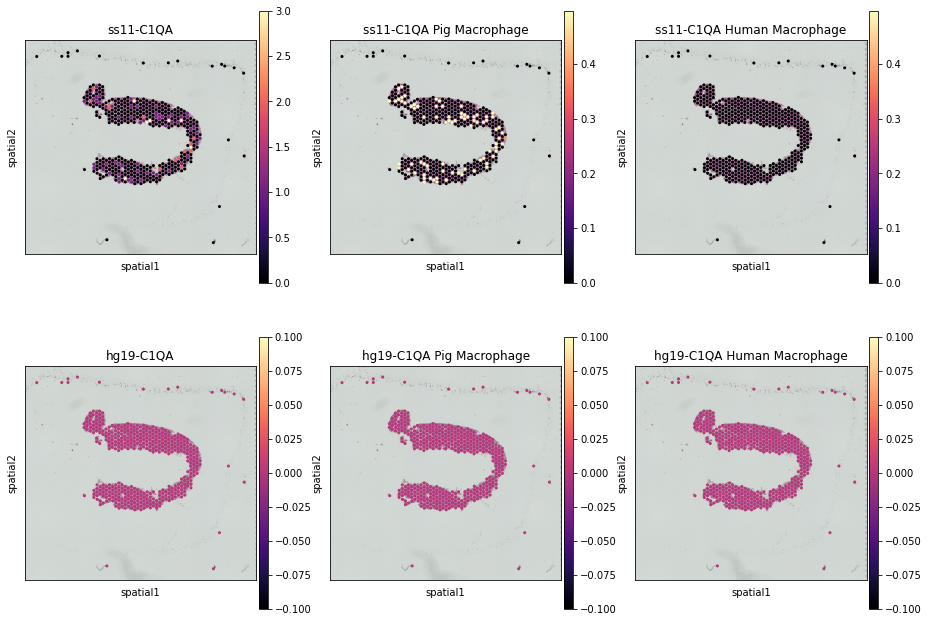

In [74]:
# from tutorial_utils import plot_genes_per_cell_type
# list cell types and genes for plotting
ctypes = ['Pig Macrophage', 'Human Macrophage']
genes = ['ss11-C1QA', 'hg19-C1QA'] # macrophage C1QA

with mpl.rc_context({'axes.facecolor':  'black'}):
    # select one slide
    slide = select_slide(adata_vis, 'D4BX1R_ph')
    
    # from tutorial_utils import plot_genes_per_cell_type
    plot_genes_per_cell_type(slide, genes, ctypes);

Note that `plot_genes_per_cell_type` function often needs customization so it is not included into cell2location package - we needed to copy it from https://github.com/BayraktarLab/cell2location/blob/master/docs/notebooks/tutorial_utils.py

## Advanced use <a name="advanced"></a>

### Working with the posterior distribution and computing arbitrary quantiles <a name="Working-with-the-posterior-distribution-and-computing-arbitrary-quantiles"></a>

In addition to the posterior distribution mean, std and quantiles presented earlier in the notebook we can fetch an arbitrary number of samples from the posterior distribution. To limit memory use, it could be beneficial to select particular varibles in the model. 

Note that this analysis requires substantial amount RAM memory.

In [75]:
# get posterior distribution samples for specific variables
samples_w_sf = mod.sample_posterior(num_samples = 1000, use_gpu = True, return_samples = True,
                                    batch_size = 2500,
                                    return_sites = ['w_sf', 'm_g', 'u_sf_mRNA_factors'])
# samples_w_sf['posterior_samples'] contains 1000 samples as arrays with dim=(num_samples, ...)
samples_w_sf['posterior_samples']['w_sf'].shape

Sampling global variables, sample: 100%|██████████| 999/999 [00:18<00:00, 52.85it/s]


(1000, 430, 13)

Finally, it could be useful to compute arbitrary quantiles of the posterior distribution.

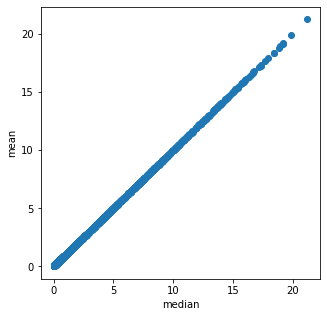

In [76]:
# compute any quantile of the posterior distribution
medians = mod.posterior_quantile(q = 0.5, batch_size = mod.adata.n_obs, use_gpu = True)

with mpl.rc_context({'axes.facecolor':  'white',
                     'figure.figsize': [5, 5]}):
    plt.scatter(medians['w_sf'].flatten(), mod.samples['post_sample_means']['w_sf'].flatten());
    plt.xlabel('median');
    plt.ylabel('mean');

In [77]:
adata_vis_obs_bx1 = adata_vis.obs
from pathlib import Path  
filepath = Path('tables/adata_vis_obs_bx1Extended.csv')  
filepath.parent.mkdir(parents = True, exist_ok = True)  
adata_vis_obs_bx1.to_csv(filepath) 

### Modules and their versions used for this analysis


Useful for debugging and reporting issues.

In [78]:
cell2location.utils.list_imported_modules()

sys 3.7.13 (default, Mar 29 2022, 02:18:16) 
[GCC 7.5.0]
ipykernel 6.15.1
ipykernel._version 6.15.1
re 2.2.1
json 2.0.9
jupyter_client 7.3.4
jupyter_client._version 7.3.4
traitlets 5.3.0
traitlets._version 5.3.0
logging 0.5.1.2
zmq 23.2.1
platform 1.0.8
ctypes 1.1.0
_ctypes 1.1.0
zmq.sugar 23.2.1
zmq.sugar.version 23.2.1
socketserver 0.4
argparse 1.1
tornado 6.2
zlib 1.0
colorama 0.4.5
_curses b'2.2'
dateutil 2.8.2
dateutil._version 2.8.2
six 1.16.0
decimal 1.70
_decimal 1.70
jupyter_core 4.11.1
jupyter_core.version 4.11.1
entrypoints 0.4
IPython 7.34.0
IPython.core.release 7.34.0
IPython.core.crashhandler 7.34.0
pygments 2.12.0
pexpect 4.8.0
ptyprocess 0.7.0
decorator 5.1.1
pickleshare 0.7.5
backcall 0.2.0
sqlite3 2.6.0
sqlite3.dbapi2 2.6.0
_sqlite3 2.6.0
prompt_toolkit 3.0.30
wcwidth 0.2.5
jedi 0.18.1
parso 0.8.3
IPython.core.magics.code 7.34.0
urllib.request 3.7
psutil 5.9.1
debugpy 1.6.2
debugpy.public_api 1.6.2
xmlrpc.client 3.7
http.server 0.6
pkg_resources._vendor.more_itertools

### End!!!